In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 100.0          # Length of the domain
T = 100.0          # Total time
Nx = 100           # Number of grid points in x
Ny = 100           # Number of grid points in y
Nt = 10000         # Number of time steps
D_u = 0.16         # Diffusion coefficient for U
D_v = 0.08         # Diffusion coefficient for V
F = 0.04           # Feed rate of U
k = 0.06           # Kill rate of V
dt = 1.0         # Time step
coarse_factor = 2  # Coarse-graining factor (e.g., averaging over 2x2 blocks)

In [3]:
dx = L / (Nx - 1)
dy = L / (Ny - 1)
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

In [4]:
# Initialize concentrations
U = np.ones((Nx, Ny)) 
V = np.zeros((Nx, Ny)) 

In [5]:
U[40:60, 40:60] = 0.5
V[40:60, 40:60] = 0.25

In [6]:
# Store the fine-scale dynamics for U
fine_scale_dynamics = np.zeros((Nt, Nx, Ny))

# Time-stepping loop for fine-scale dynamics
for n in range(Nt):
    fine_scale_dynamics[n] = U
    
    laplacian_U = (np.roll(U, 1, axis=0) + np.roll(U, -1, axis=0) +
                   np.roll(U, 1, axis=1) + np.roll(U, -1, axis=1) - 4 * U) / (dx * dy)
    
    laplacian_V = (np.roll(V, 1, axis=0) + np.roll(V, -1, axis=0) +
                   np.roll(V, 1, axis=1) + np.roll(V, -1, axis=1) - 4 * V) / (dx * dy)

    # GS model
    U += (D_u * laplacian_U - U * V**2 + F * (1 - U)) * dt
    V += (D_v * laplacian_V + U * V**2 - (F + k) * V) * dt

In [7]:
# Coarse-grain the fine-scale dynamics
def coarse_grain(data, factor):
    return data.reshape(data.shape[0], data.shape[1] // factor, factor, data.shape[2] // factor, factor).mean(axis=(2, 4))

In [8]:
# Generate coarse-grained dynamics
coarse_scale_dynamics = coarse_grain(fine_scale_dynamics, coarse_factor)

In [9]:
from scipy.ndimage import gaussian_filter

sigma = 4  

# Apply the Gaussian filter to each image
blurred_fine_scale_dynamics = np.empty_like(fine_scale_dynamics)
for i in range(fine_scale_dynamics.shape[0]):
    blurred_fine_scale_dynamics[i] = gaussian_filter(fine_scale_dynamics[i], sigma=sigma)

In [10]:
fine_scale_dynamics -= np.min(fine_scale_dynamics)
fine_scale_dynamics /= np.max(fine_scale_dynamics)

In [11]:
coarse_scale_dynamics -= np.min(coarse_scale_dynamics)
coarse_scale_dynamics /= np.max(coarse_scale_dynamics)

In [12]:
blurred_fine_scale_dynamics -= np.min(blurred_fine_scale_dynamics)
blurred_fine_scale_dynamics /= np.max(blurred_fine_scale_dynamics)

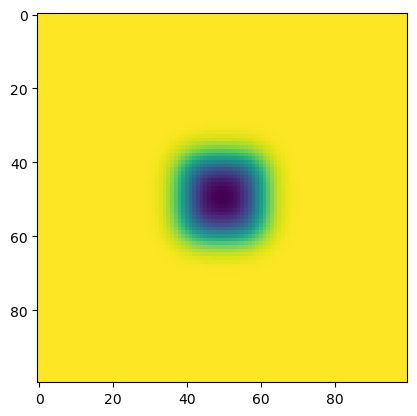

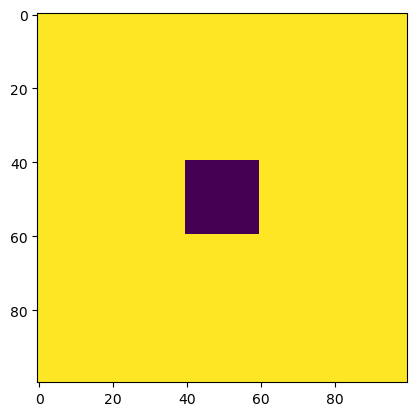

In [13]:
plt.imshow(blurred_fine_scale_dynamics[0])
plt.show()
plt.imshow(fine_scale_dynamics[0])

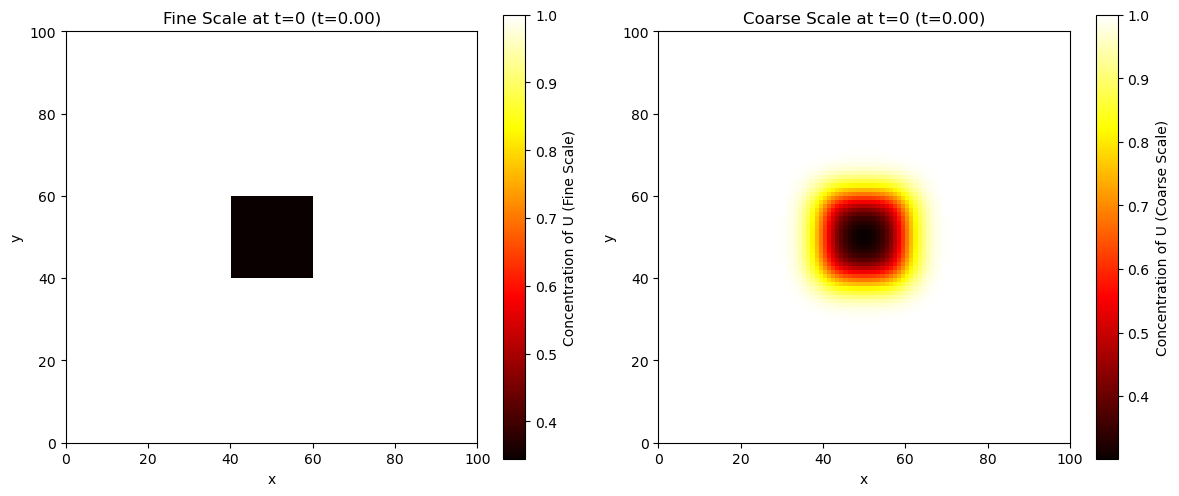

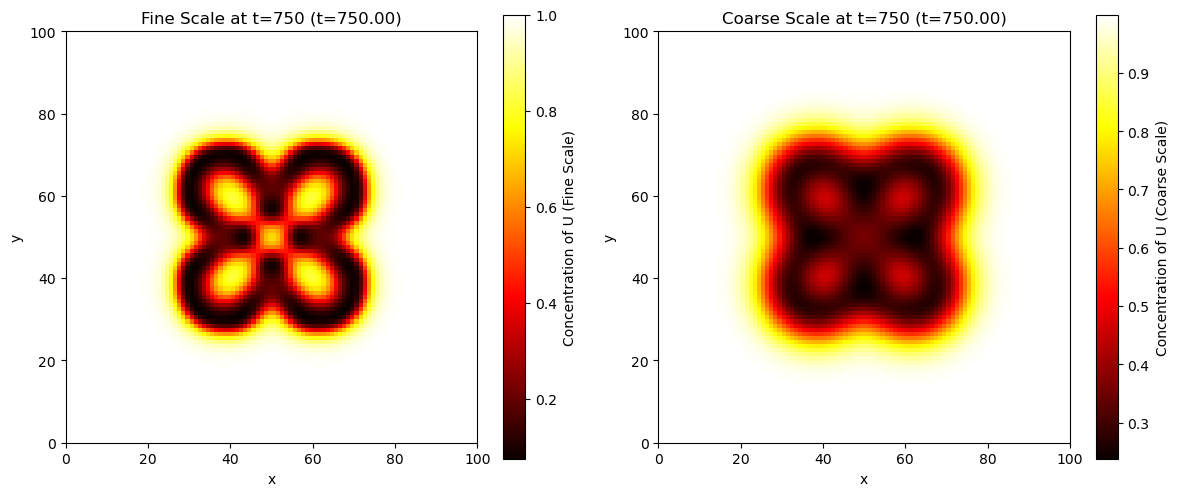

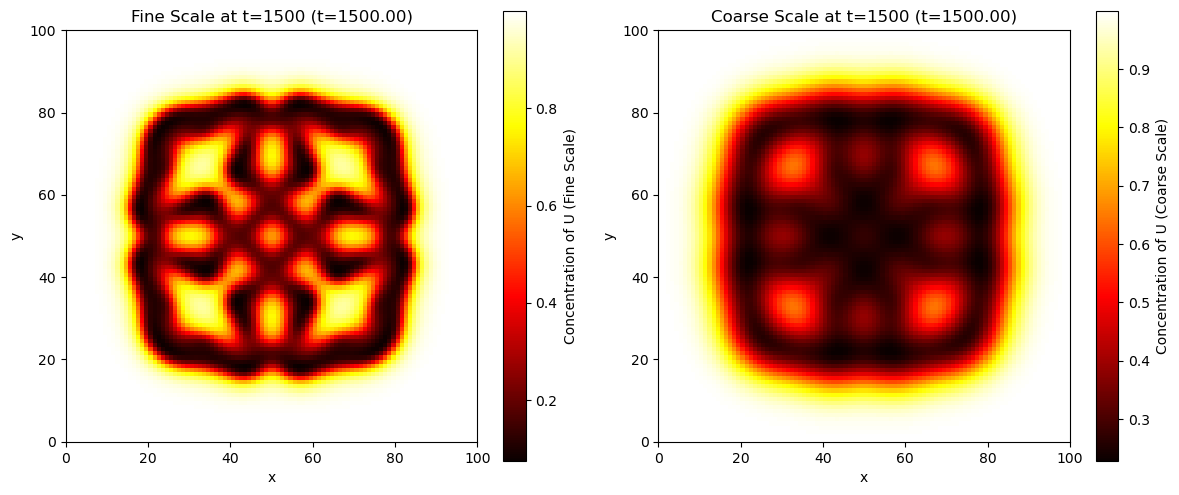

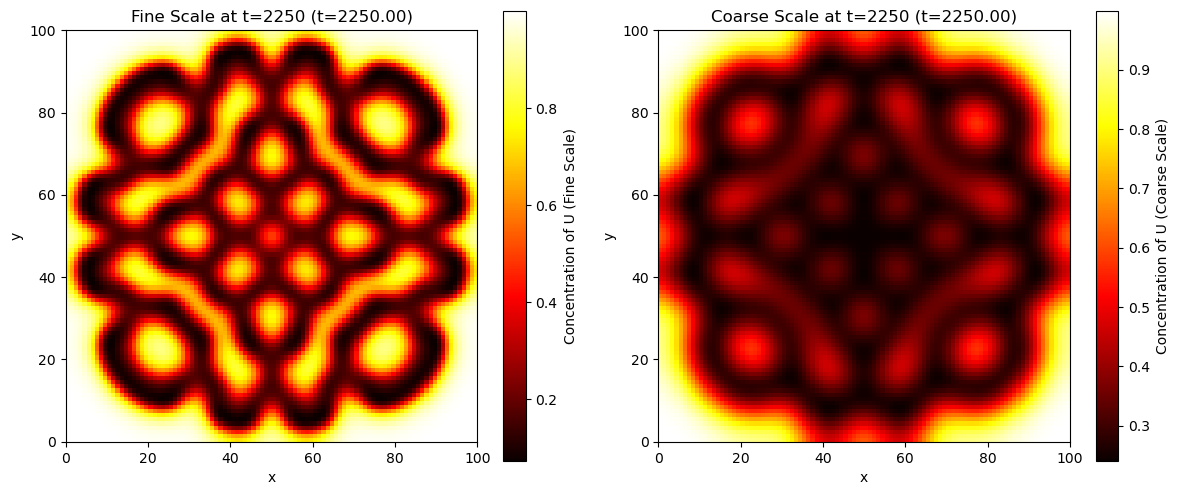

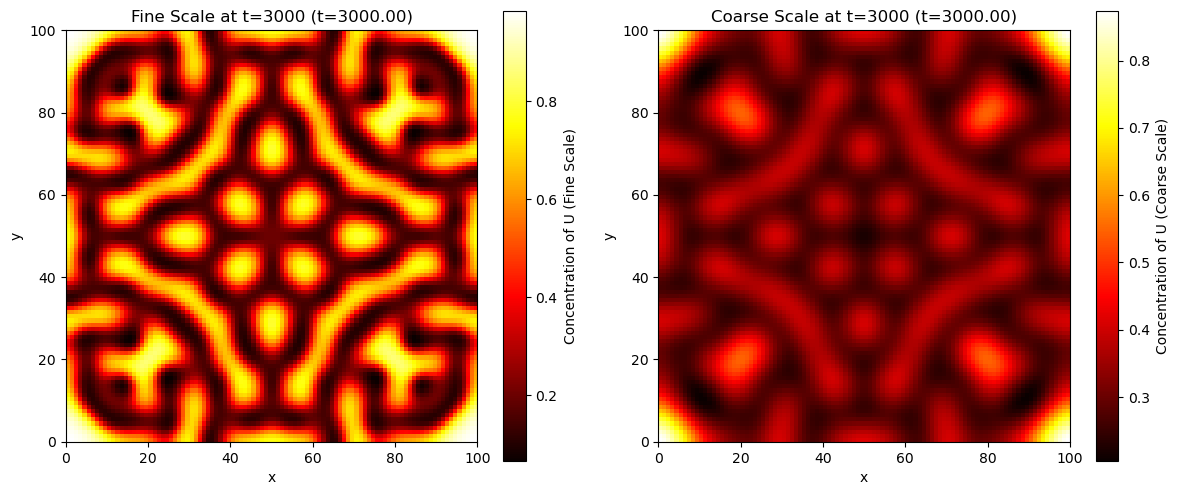

In [14]:
# Visualize the comparison of fine-scale and coarse-grained dynamics
num_snapshots = 5  # Number of snapshots to visualize
time_indices = np.linspace(0, 3000, num_snapshots, dtype=int)

for idx in time_indices:
    # Fine-scale dynamics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(fine_scale_dynamics[idx], extent=[0, L, 0, L], origin='lower', cmap='hot')
    plt.colorbar(label='Concentration of U (Fine Scale)')
    plt.title(f'Fine Scale at t={idx} (t={idx*dt:.2f})')
    plt.xlabel('x')
    plt.ylabel('y')

    # Coarse-grained dynamics
    plt.subplot(1, 2, 2)
    plt.imshow(blurred_fine_scale_dynamics[idx], extent=[0, L, 0, L], origin='lower', cmap='hot')
    plt.colorbar(label='Concentration of U (Coarse Scale)')
    plt.title(f'Coarse Scale at t={idx} (t={idx*dt:.2f})')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.tight_layout()
    plt.show()

In [15]:
with open('/pscratch/sd/h/hbassi/toy_pde_data_fine_scale_blurred.npy', 'wb') as f:
    np.save(f, blurred_fine_scale_dynamics[750:])

In [16]:
with open('/pscratch/sd/h/hbassi/toy_pde_data_fine_scale.npy', 'wb') as f:
    np.save(f, fine_scale_dynamics[750:])

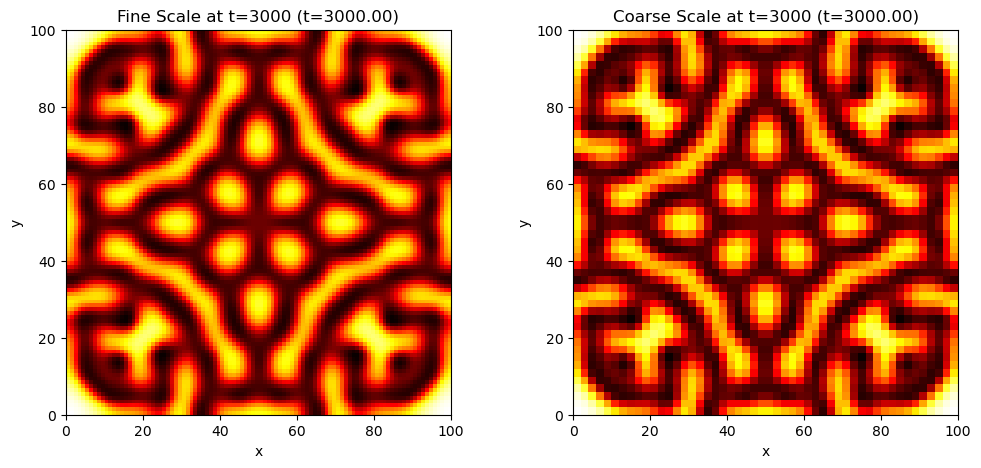

In [17]:
import matplotlib.animation as animation

# Set up figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

def update_plot(idx):
    ax1.clear()
    ax2.clear()

    # Fine-scale dynamics
    im1 = ax1.imshow(fine_scale_dynamics[idx], extent=[0, L, 0, L], origin='lower', cmap='hot')
    ax1.set_title(f'Fine Scale at t={idx} (t={idx*dt:.2f})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    

    # Coarse-grained dynamics
    im2 = ax2.imshow(coarse_scale_dynamics[idx], extent=[0, L, 0, L], origin='lower', cmap='hot')
    ax2.set_title(f'Coarse Scale at t={idx} (t={idx*dt:.2f})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')

# Generate time indices to animate
num_snapshots = 100 # Number of snapshots to visualize
time_indices = np.linspace(0, 3000, num_snapshots, dtype=int)

# Create an animation object
ani = animation.FuncAnimation(fig, update_plot, frames=time_indices, repeat=False)

# Save as a gif
ani.save('dynamics_comparison.gif', writer='imagemagick', fps=1)  # Adjust fps as needed

plt.show()
